## Der Kluge reist auf der Sparschiene 
Die SBB bieten mehr Sparbilette denn je an. In den letzten Monaten wurden die Ticketpreise, wie sie via den Fahrplan ersichtlich sind, von einem Computerskript automatisch ausgelesen. Nachfolgend werden die dabei entstandenen Daten eingelesen und aufbereitet.  

In [1]:
# Importieren der nötigen Bibliotheken. 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

from tqdm import tqdm_notebook
import concurrent.futures
import numpy as np
import multiprocessing

In [2]:
# Die Daten werden eingelesen. 
df = pd.read_csv('daten/sparbillette.csv', index_col='Unnamed: 0')

In [3]:
df.head()

,datetime,datum,start,ziel,zeit,abfahrt,ankunft,dauer,umsteigen,belegung_1,...,im_voraus_kat,abfahrt_datetime,strecke,normalpreis,preis_prozent,sparticket,kilometer_x,kilometerpreis,kilometer_y,kilometer
0,2019-10-24 22:49:45,2019-10-25 00:00:00,Bern,"Lugano, Vignola",16:00,16:02,19:43,3 h 41 min,3,"1. Klasse, Sehr hohe Belegung erwartet",...,-1,2019-10-25 16:02:00,"Bern -- Lugano, Vignola",54.0,100.0,False,NaN,NaN,NaN,NaN
1,2019-10-24 22:49:45,2019-10-25 00:00:00,Bern,"Lugano, Vignola",16:00,16:10,20:21,4 h 11 min,3,"1. Klasse, Hohe Belegung erwartet",...,-1,2019-10-25 16:10:00,"Bern -- Lugano, Vignola",54.0,100.0,False,NaN,NaN,NaN,NaN
2,2019-10-24 22:49:45,2019-10-25 00:00:00,Bern,"Lugano, Vignola",16:00,17:00,20:51,3 h 51 min,3,"1. Klasse, Sehr hohe Belegung erwartet",...,-1,2019-10-25 17:00:00,"Bern -- Lugano, Vignola",54.0,88.9,True,NaN,NaN,NaN,NaN
3,2019-10-24 22:49:45,2019-10-25 00:00:00,Bern,"Lugano, Vignola",16:00,18:02,21:51,3 h 49 min,3,"1. Klasse, Hohe Belegung erwartet",...,-1,2019-10-25 18:02:00,"Bern -- Lugano, Vignola",54.0,100.0,False,NaN,NaN,NaN,NaN
4,2019-10-24 22:49:45,2019-10-25 00:00:00,Bern,"Lugano, Vignola",16:00,19:00,22:51,3 h 51 min,3,"1. Klasse, Tiefe bis mittlere Belegung erwartet",...,-1,2019-10-25 19:00:00,"Bern -- Lugano, Vignola",54.0,88.9,True,NaN,NaN,NaN,NaN


In [4]:
# Eine Korrektur. Einige Ortsbezeichnungen enthalten einen Leerschlag am Ende. Dieser wird entfernt. 
df['start'] = df['start'].str.strip()
df['ziel'] = df['ziel'].str.strip()

# Einige Seiten wurden in französischer, englischer oder italiensischer Sprache geliefert. 
#Die Ortsbezeichnungen werden korrigiert.
df['start'] = df['start'].str.replace('de ', '')
df['start'] = df['start'].str.replace('from ', '')
df['start'] = df['start'].str.replace('da ', '')

df['ziel'] = df['ziel'].str.replace('à ', '')
df['ziel'] = df['ziel'].str.replace('a ', '')
df['ziel'] = df['ziel'].str.replace('to ', '')

# Allfällige Duplikate werden entfernt.  
df = df.drop_duplicates()

# Das Datum wird in besser verarbeitbare Form gebracht. 
df['datum'] = pd.to_datetime(df['datum'], dayfirst=True)

In [5]:
# Weitere Korrekturen, da beim Scraper die Schreibweise geändert werden musste. 
df['start'] = df['start'].replace('Bern, Hauptbahnhof', 'Bern')
df['ziel'] = df['ziel'].replace('Bern, Hauptbahnhof', 'Bern')

In [6]:
# In etlichen Einträgen ist kein Preis verzeichnet. Diese ignorieren wir.  
df = df[df['minimalpreis'].notnull()]

In [7]:
# Um sicherzustellen, dass wir nur Preise mit Halbtax haben, beschränken wir uns auf die eingloggt erfassten Daten. 
df = df[df['login'] == True]

In [8]:
# Fälschlicherweise wurden einige Fahrten innerhalb eines Ortes erfasst. Diese werden herausgefiltert. 
# Da dies mitunter lange dauert, wird auf mehreren Kernen parallel gerechnet. 
num_processes = multiprocessing.cpu_count() - 1

def worker(s, z):
    if s in z:
        return 'löschen'
    else:
        return 'ok'

# Process the rows in chunks in parallel
with concurrent.futures.ProcessPoolExecutor(num_processes) as pool:
    df['löschen'] = list(tqdm_notebook(pool.map(worker, df['start'], df['ziel'], chunksize=10), total=df.shape[0])) # With a progressbar
df = df[df['löschen'] != 'löschen']
del df['löschen']

In [9]:
# Die Differenz in Tagen zwischen dem Scraping-Zeitpunkt und dem gewünschten Fahrzeitpunkt wird errechnet. 
df['datum'] = pd.to_datetime(df['datum'])
df['datetime'] = pd.to_datetime(df['datetime'])
df['im_voraus'] = (df['datetime'] - df['datum']).apply(lambda x: x.days)

In [10]:
# Die errechnete Zahl kann um rund zwei Tage varieren. Deshalb runden wir auf die halbe Woche. 
def insrichigetöpfli(v):
    for i in [0, 3, 7, 14, 30, 58]:
        if abs(abs(v) - abs(i)) <= 1:
            return -i
        
df['im_voraus_kat'] = df['im_voraus'].apply(insrichigetöpfli)
df['im_voraus_kat'] = df['im_voraus_kat'].replace(0, -1)

In [11]:
# Der Abfahrtszeitpunkt wird als Datetime abgelegt.
df['abfahrt_datetime'] = pd.to_datetime(df['datum'].astype('str') + ' ' + df['abfahrt'])

In [12]:
# Einfügen der Streckenbezeichnung, damit später einfacher sortiert werden kann.  
df['strecke'] = df['start'] + ' -- ' + df['ziel']

In [13]:
# Berechnen, wie viel Prozent des regulären Halbtaxpreises (bzw. des am maximalen Preises) 
# das günstigste Ticket kostet. Achtung: Die verschiedenen Wege werden nicht berücksichtigt. 
# Ausschlaggebend ist lediglich, wie oft man umsteigen muss. 
df_temp_1 = pd.DataFrame()
for s in df['strecke'].unique():
    for u in df[df['strecke'] == s]['umsteigen'].unique():
        df_temp = df[(df['strecke'] == s) & (df['umsteigen'] == u)]
        normalpreis = df_temp['minimalpreis'].max()
        df_temp['normalpreis'] = normalpreis
        
        # Bei drei Strecken entspricht der Maximalpreis nicht dem Normalpreis. Diese werden manuell korrigiert. 
        for i, r in df_temp.iterrows():
            if r['strecke'] == 'Bern -- Thun':
                df_temp.at[i, 'normalpreis'] = 8.20
                normalpreis = 8.20
            elif r['strecke'] == 'Thun -- Bern':
                df_temp.at[i, 'normalpreis'] = 8.20
                normalpreis = 8.20
            elif r['strecke'] == 'Zürich HB -- Chur':
                df_temp.at[i, 'normalpreis'] = 20.50
                normalpreis = 20.50
            elif r['strecke'] == 'Chur -- Zürich HB':
                df_temp.at[i, 'normalpreis'] = 20.50
                normalpreis = 20.50
            elif r['strecke'] == 'Bern -- Zürich HB':
                df_temp.at[i, 'normalpreis'] = 25.50
                normalpreis = 25.50
            elif r['strecke'] == 'Zürich HB -- Bern':
                df_temp.at[i, 'normalpreis'] = 25.50
                normalpreis = 25.50
        
        df_temp['preis_prozent'] = df_temp['minimalpreis'].apply(lambda x: round(100 * x / normalpreis, 1))
        df_temp_1 = df_temp_1.append(df_temp)
df = df_temp_1

/home/habi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/habi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [14]:
df.head()

,datetime,datum,start,ziel,zeit,abfahrt,ankunft,dauer,umsteigen,belegung_1,...,im_voraus_kat,abfahrt_datetime,strecke,normalpreis,preis_prozent,sparticket,kilometer_x,kilometerpreis,kilometer_y,kilometer
0,2019-10-24 22:49:45,2019-10-25,Bern,"Lugano, Vignola",16:00,16:02,19:43,3 h 41 min,3,"1. Klasse, Sehr hohe Belegung erwartet",...,-1,2019-10-25 16:02:00,"Bern -- Lugano, Vignola",54.0,100.0,False,NaN,NaN,NaN,NaN
1,2019-10-24 22:49:45,2019-10-25,Bern,"Lugano, Vignola",16:00,16:10,20:21,4 h 11 min,3,"1. Klasse, Hohe Belegung erwartet",...,-1,2019-10-25 16:10:00,"Bern -- Lugano, Vignola",54.0,100.0,False,NaN,NaN,NaN,NaN
2,2019-10-24 22:49:45,2019-10-25,Bern,"Lugano, Vignola",16:00,17:00,20:51,3 h 51 min,3,"1. Klasse, Sehr hohe Belegung erwartet",...,-1,2019-10-25 17:00:00,"Bern -- Lugano, Vignola",54.0,88.9,True,NaN,NaN,NaN,NaN
3,2019-10-24 22:49:45,2019-10-25,Bern,"Lugano, Vignola",16:00,18:02,21:51,3 h 49 min,3,"1. Klasse, Hohe Belegung erwartet",...,-1,2019-10-25 18:02:00,"Bern -- Lugano, Vignola",54.0,100.0,False,NaN,NaN,NaN,NaN
4,2019-10-24 22:49:45,2019-10-25,Bern,"Lugano, Vignola",16:00,19:00,22:51,3 h 51 min,3,"1. Klasse, Tiefe bis mittlere Belegung erwartet",...,-1,2019-10-25 19:00:00,"Bern -- Lugano, Vignola",54.0,88.9,True,NaN,NaN,NaN,NaN


['Bern', 'Zürich HB']


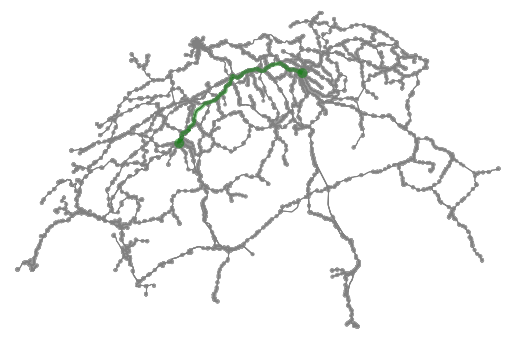

118.7013289999999

['Basel SBB', 'Zürich HB']


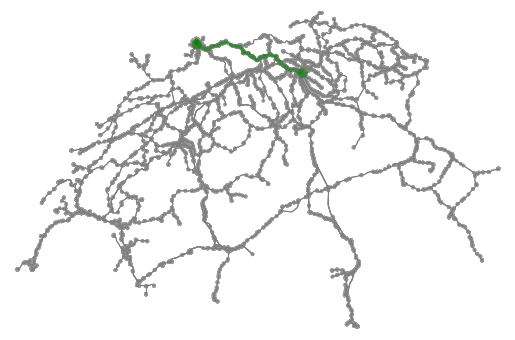

95.383087

['Basel SBB', 'Bern']


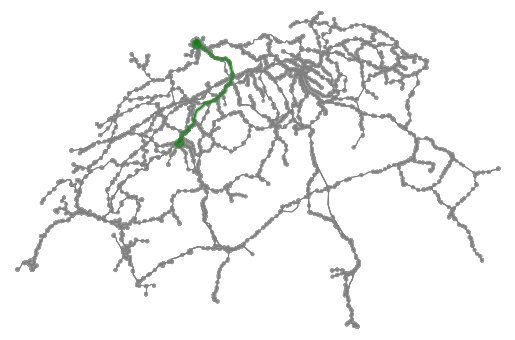

109.34288999999997

['Genève', 'Zürich HB']


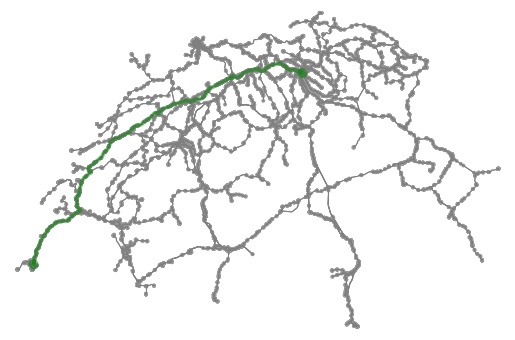

266.4858309999999

['Genève', 'Bern']


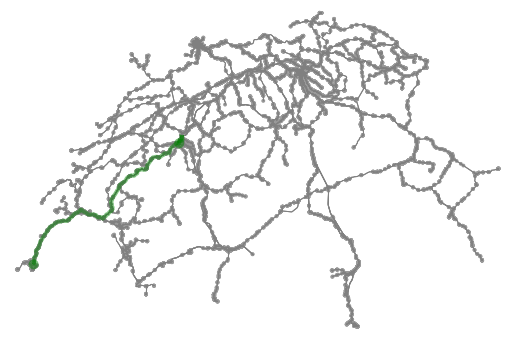

170.76780700000012

['Biel/Bienne', 'Bern']


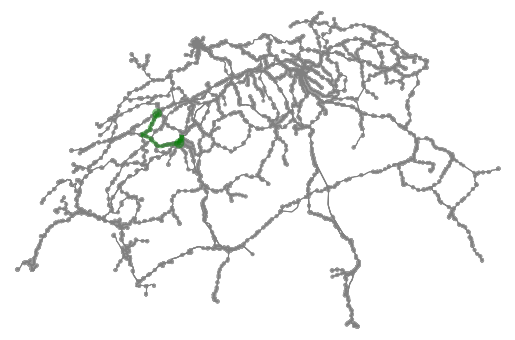

64.40411300000001

['Thun', 'Bern']


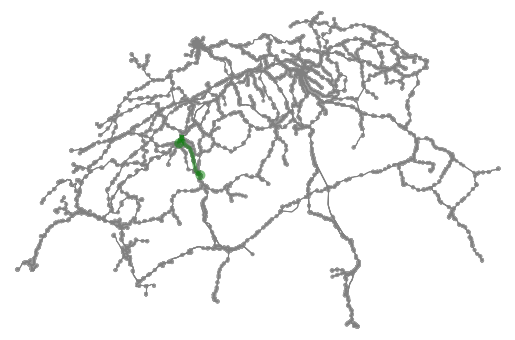

38.20118900000001

['Domodossola', 'Bern']


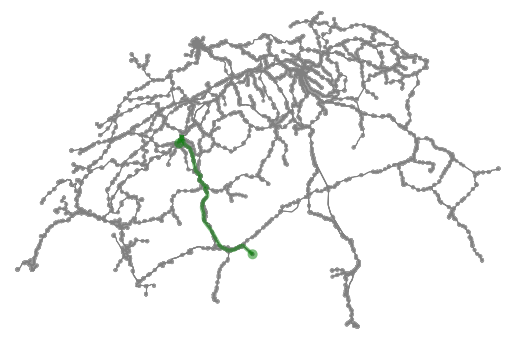

121.15988700000003

['Winterthur', 'Zürich HB']


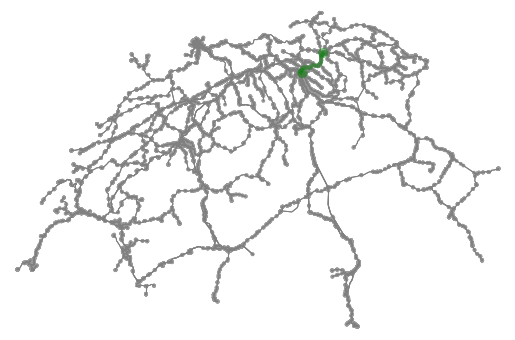

27.210651000000002

['Chur', 'Zürich HB']


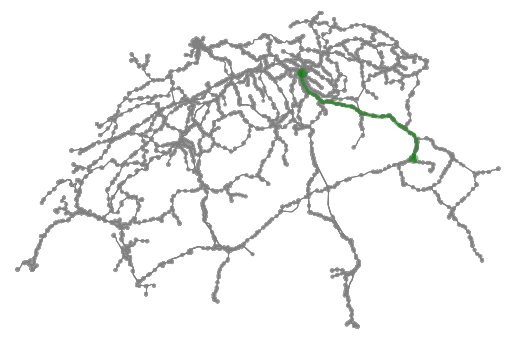

115.6071430000001

['Bern', 'Biel/Bienne']


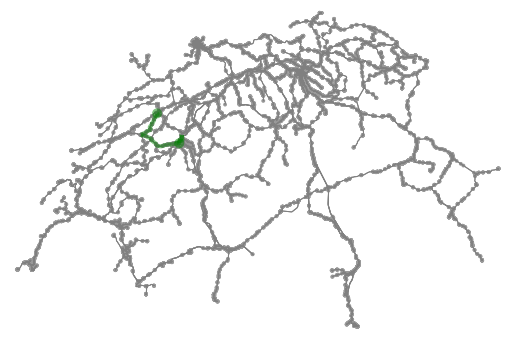

64.40411300000001



In [15]:
# Berechnen der Distanzen. Achtung: Es dauert lange, bis die nötigen Geodatengeladen 
# und die Berechnungen gemacht sind. 
import osmnx as ox
import networkx as nx

# Herunterladen der Zugsstrecken der Schweiz. Achtung: Das nimmt sehr viel Zeit in Anspruch.
G = ox.graph_from_place('Switzerland',
                        network_type='none',
                        infrastructure='way["railway"]',
                        simplify=True)

strecken = [['Bern', 'Zürich HB'],
            ['Basel SBB', 'Zürich HB'],
            ['Basel SBB', 'Bern'],
            ['Genève', 'Zürich HB'],
            ['Genève', 'Bern'],
            ['Biel/Bienne', 'Bern'],
            ['Thun', 'Bern'],
            ['Domodossola', 'Bern'], 
            ['Winterthur', 'Zürich HB'],
            ['Chur', 'Zürich HB'],
            ['Bern', 'Biel/Bienne']]

bh_latlon = {'Zürich HB': [47.37811, 8.53926],
             'Bern': [46.94917, 7.43931],
             'Genève': [46.21020, 6.14261],
             'Basel SBB': [47.5526,7.5943], 
             'Winterthur': [47.50039, 8.72360],
             'Thun': [46.75473, 7.62965],
             'Biel/Bienne': [47.13296, 7.24322], 
             'Chur': [46.85379, 9.52937],
             'Lugano': [46.00512, 8.94703],
             'Domodossola': [46.11541, 8.29664]}

df_bahnhof = pd.DataFrame.from_dict(bh_latlon, orient='index')
df_bahnhof.columns = ['lat', 'lon']

# Berechnen der nächsten Nodes auf dem Streckenplan. 
for i, r in df_bahnhof.iterrows():
    df_bahnhof.at[i, 'node'] = ox.get_nearest_node(G, [r['lat'], r['lon']])
    
# Berechnen der Distanz. 
distanz_dict = dict()

for s in strecken:
    n1 = df_bahnhof.loc[s[0]]['node']
    n2 = df_bahnhof.loc[s[1]]['node']
    
    print(s)
    route = nx.shortest_path(G, n1, n2, weight='length')
    fig, ax = ox.plot_graph_route(G, route, fig_height=8, fig_width=8, 
                        show=True, close=False, 
                        edge_color='grey',
                        orig_dest_node_color='green',
                        route_color='green')
    length = nx.shortest_path_length(G, n1, n2, weight='length')
    print(length / 1000)
    print()
    distanz_dict[' -- '.join(s)] = round(length / 1000, 3)
    
# Zusammenführen der beiden Dataframes. 
df_distanzen = pd.DataFrame.from_dict(distanz_dict, orient='index')#df_distanzen = df_distanzen.reset_index()
df_distanzen = df_distanzen.reset_index()
df_distanzen['index'] = df_distanzen['index'].str.replace('bern', 'Bern')
df_distanzen['index'] = df_distanzen['index'].str.replace('bern', 'Bern')
df_distanzen['index'] = df_distanzen['index'].str.replace('zürich', 'Zürich HB')
df_distanzen['index'] = df_distanzen['index'].str.replace('basel', 'Basel SBB')
df_distanzen['index'] = df_distanzen['index'].str.replace('genève', 'Genève')
df_distanzen['index'] = df_distanzen['index'].str.replace('basel', 'Basel SBB')

df_distanzen.columns = ['strecke', 'kilometer']

# Abspeichern der generierten Daten. 
df_distanzen.to_csv('daten/distanzen.csv')

In [16]:
# Neu laden der Distanzangaben.
df_distanzen = pd.read_csv('daten/distanzen.csv', index_col='Unnamed: 0')

In [19]:
# Zusammenführen der beiden Datensätze. 
df = pd.merge(df, df_distanzen, left_on='strecke', right_on='strecke', how='left')

# Berechnen des Preises pro Kilometer. 
df['kilometerpreis'] = df['minimalpreis'] / df['kilometer'] * 100

In [20]:
# Duplikate werden entfernt. 
df = df.drop_duplicates(subset=['datetime',
                                'datum',
                                'start',
                                'ziel',
                                'zeit',
                                'abfahrt',
                                'ankunft',
                                'dauer',
                                'umsteigen'])

In [21]:
# Zwischenspeichern der Daten. 
df.to_csv('daten/sparbillette.csv')

### Plausibilitätschecks

In [22]:
# Wie viele Einträge sind vorhanden? 
len(df)

182817

In [23]:
# Wann wurde zum ersten Mal gescrapt?
df['datetime'].min()

Timestamp('2019-09-11 14:57:54')

In [24]:
# Wann wurde zum letzten Mal gescrapt?
df['datetime'].max()

Timestamp('2019-11-24 00:06:40')

In [25]:
# Welches ist der erste erfasste Fahrtag?
df['datum'].min()

Timestamp('2019-09-12 00:00:00')

In [26]:
# Welches ist der letzte erfasste Fahrtag?
df['datum'].max()

Timestamp('2020-01-20 00:00:00')

In [27]:
# Welche Strecken wurden wie oft ausgelesen? 
df['strecke'].value_counts()

Bern -- Zürich HB                      12909
Basel SBB -- Zürich HB                  8894
Zürich HB -- Bern                       8014
Genève -- Zürich HB                     7298
Chur -- Zürich HB                       7100
                                       ...  
Zürich HB -- Bern Bümpliz Nord            10
Basel SBB -- Oberwinterthur                9
Basel SBB -- Biel/Bienne, Redernweg        9
Biel/Bienne -- Thun, Untere Wart           7
Genève -- Zürich, Bernoulli-Häuser         7
Name: strecke, Length: 195, dtype: int64

In [28]:
# Welche Start-Adressen sind verzeichnet? 
df['start'].unique().tolist()

['Bern',
 'Zürich HB',
 'Genève',
 'Winterthur, Turmstrasse',
 'Baden',
 'Basel SBB',
 'Winterthur, Hauptbahnhof',
 'Chur',
 'Thun',
 'Lugano',
 'Domodossola, Stazione',
 'Biel/Bienne']

In [29]:
# Welche Ziel-Adressen sind verzeichnet?
df['ziel'].unique().tolist()

['Lugano, Vignola',
 'Bern',
 'Zürich HB',
 'Basel SBB',
 'Biel/Bienne',
 'Bern, Wankdorf Center',
 'Genève',
 'Lugano',
 'Bern Flughafen',
 'Berneck, Rosenberg',
 'Zürich, Hallenbad Oerlikon',
 'Domodossola, Stazione',
 'Bern, Inselplatz',
 'Bern Brünnen Westside, Bahnhof',
 'Thun',
 'Oberwinterthur',
 'Bern Marzili',
 'Biel/Bienne, Bellevue',
 'Zürich, Berninaplatz',
 'Bern, Galgenfeld',
 'Basel, Züribieter (Restaurant)',
 'Chur',
 'Winterthur, Hauptbahnhof',
 'Winterthur, Hinterwiesli',
 'Basel, Bernerring',
 'Bern, Pfisternbeck (Restaurant)',
 'Thun, Untere Wart',
 'Zürich, Churchill',
 'Baden',
 'Zürich, SBB-Werkstätte',
 'Bern Brünnen Westside',
 'Bern, Bierhübeli',
 'Bern Bümpliz',
 'Zürich, Haldenbach',
 'Zürich, Bernoulli-Häuser',
 'Zürich, Albisriederplatz',
 'Zürich, Apotheke im Hauptbahnhof',
 'Zürich Wipkingen',
 'Winterthur, Turmstrasse',
 'Genf, Churchill (Hotel)',
 'Zürich, Kirche Fluntern',
 'Winterthur, Rosenberg',
 'Zürich, Zwielplatz',
 'Biel/Bienne, Bubenbergstrass